# Preparation

In [73]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from datetime import datetime

In [30]:
# import os
# from PIL import Image

# dataset_path = "C:/Users/kuhak/.keras/datasets/leaf_detect/not_leaf"

# for folder in os.listdir(dataset_path):
#     folder_path = os.path.join(dataset_path, folder)
#     if os.path.isdir(folder_path):  # Ensure it's a directory
#         for file in os.listdir(folder_path):
#             file_path = os.path.join(folder_path, file)
#             try:
#                 img = Image.open(file_path)
#                 img.verify()  # Check if the file is valid
#             except (IOError, SyntaxError) as e:
#                 print(f"Corrupt image: {file_path}")
#                 os.remove(file_path)  # Remove the corrupt file


# Load Data

In [31]:
import pathlib
import kagglehub

# Download latest version
# data_dir = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

# dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
# data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
# data_dir = pathlib.Path(data_dir)

In [32]:
data_dir="C:/Users/kuhak/.keras/datasets/leaf_detect/"
data_dir=pathlib.Path(data_dir)
print(data_dir)

C:\Users\kuhak\.keras\datasets\leaf_detect


In [33]:
# data_val_dir="C:/Users/kuhak/.keras/datasets/downloaded_images/"
# data_val_dir=pathlib.Path(data_val_dir)
# print(data_val_dir)

In [34]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

48


In [35]:
# image_count = len(list(data_val_dir.glob('*/*.jpg')))
# print(image_count)

In [36]:
roses = list(data_dir.glob('Bacterial Spot/*'))
# PIL.Image.open(str(roses[0]))

# Buat kumpulan data

In [37]:
batch_size = 32
img_height = 180
img_width = 180

In [38]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 48 files belonging to 2 classes.
Using 39 files for training.


In [39]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 48 files belonging to 2 classes.
Using 9 files for validation.


In [40]:
class_names = train_ds.class_names
print(class_names)

['leaf', 'not_leaf']


# Visualisasi Data

In [41]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

# Buat Modelnya

# Konfigurasikan kumpulan data untuk kinerja 

In [42]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Normalisasi

In [43]:
# normalization_layer = layers.Rescaling(1./255)

In [44]:
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

# Augmentasi

In [45]:
# data_augmentation = keras.Sequential(
#   [
#     layers.RandomFlip("horizontal",
#                       input_shape=(img_height,
#                                   img_width,
#                                   3)),
#     layers.RandomRotation(0.1),
#     layers.RandomZoom(0.1),
#   ]
# )

In [46]:
# plt.figure(figsize=(10, 10))
# for images, _ in train_ds.take(1):
#   for i in range(9):
#     augmented_images = data_augmentation(images)
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(augmented_images[0].numpy().astype("uint8"))
#     plt.axis("off")

In [47]:
# augmentation = ImageDataGenerator(
#     rotation_range=15,      # Randomly rotate images in the range (degrees, 0 to 180)
#     width_shift_range=0.1,  # Randomly translate images horizontally
#     height_shift_range=0.1, # Randomly translate images vertically
#     shear_range=0.1,        # Shear angle in counter-clockwise direction in degrees
#     zoom_range=0.1,         # Randomly zoom in on images
#     horizontal_flip=True,    # Randomly flip images
#     fill_mode='nearest'     # Fill in new pixels after a transformation
# )

In [48]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.1, upper=0.2)
    return image, label

In [49]:
train_ds = train_ds.map(augment)

In [50]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [51]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [52]:
# model.summary()

# Training  

In [53]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

start_time = datetime.now()
epochs=50
history = model.fit(
  # augmentation.flow(train_ds),
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  # callbacks=[early_stopping]
)
end_time = datetime.now()

duration = end_time - start_time
print(f"Training duration: {duration}")

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 219ms/step - accuracy: 0.3643 - loss: 0.9811 - val_accuracy: 1.0000 - val_loss: 0.4379
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8558 - loss: 0.5915 - val_accuracy: 0.5556 - val_loss: 1.7086
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6357 - loss: 1.1537 - val_accuracy: 0.5556 - val_loss: 0.9263
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6357 - loss: 0.7880 - val_accuracy: 0.5556 - val_loss: 0.6452
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6528 - loss: 0.6254 - val_accuracy: 0.5556 - val_loss: 1.1108
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6357 - loss: 0.8956 - val_accuracy: 1.0000 - val_loss: 0.4371
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9658 - loss: 0.4496 - val_accuracy: 1.0000 - val_loss: 0.3573
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.3636 - val_accuracy: 0.6667 - val_loss: 0.3628

In [54]:
# test_loss, test_acc = model.evaluate(X_test, y_test)
# print(f'Test accuracy: {test_acc:.2f}, Test loss: {test_loss:.2f}')

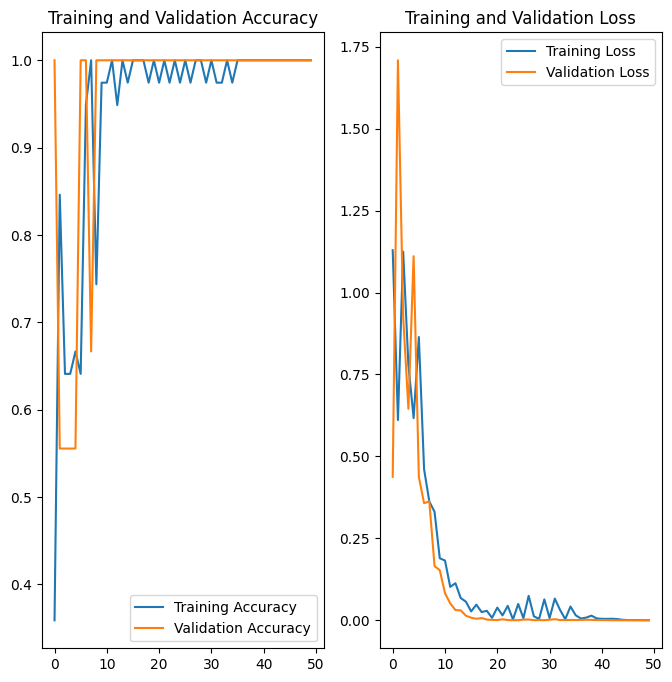

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Prediksi

In [74]:
sunflower_url = "https://files.catbox.moe/3whiyn.jpg"
sunflower_path = tf.keras.utils.get_file('person1', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x000001A500256480>

In [76]:
sunflower_path = "WIN_20250222_06_58_37_Pro.jpg"  # Change to your actual path

# Load and preprocess image
# img_height, img_width = 244, 244  # Adjust to match your model's input size
# img = tf.keras.utils.load_img(sunflower_path, target_size=(img_height, img_width))
img = tf.keras.utils.load_img(sunflower_path)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create a batch

# Predict
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Display result
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

InvalidArgumentError: Graph execution error:

Detected at node sequential_1_1/dense_2_1/Relu defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "d:\Project Kuliah\uts\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "d:\Project Kuliah\uts\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "d:\Project Kuliah\uts\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "d:\Project Kuliah\uts\Lib\site-packages\tornado\platform\asyncio.py", line 205, in start

  File "C:\Users\kuhak\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 641, in run_forever

  File "C:\Users\kuhak\AppData\Local\Programs\Python\Python312\Lib\asyncio\base_events.py", line 1986, in _run_once

  File "C:\Users\kuhak\AppData\Local\Programs\Python\Python312\Lib\asyncio\events.py", line 88, in _run

  File "d:\Project Kuliah\uts\Lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue

  File "d:\Project Kuliah\uts\Lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one

  File "d:\Project Kuliah\uts\Lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell

  File "d:\Project Kuliah\uts\Lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request

  File "d:\Project Kuliah\uts\Lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request

  File "d:\Project Kuliah\uts\Lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute

  File "d:\Project Kuliah\uts\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "d:\Project Kuliah\uts\Lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell

  File "d:\Project Kuliah\uts\Lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell

  File "d:\Project Kuliah\uts\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "d:\Project Kuliah\uts\Lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async

  File "d:\Project Kuliah\uts\Lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes

  File "d:\Project Kuliah\uts\Lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code

  File "C:\Users\kuhak\AppData\Local\Temp\ipykernel_23164\3412655843.py", line 10, in <module>

  File "d:\Project Kuliah\uts\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "d:\Project Kuliah\uts\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 510, in predict

  File "d:\Project Kuliah\uts\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 208, in one_step_on_data_distributed

  File "d:\Project Kuliah\uts\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 198, in one_step_on_data

  File "d:\Project Kuliah\uts\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 96, in predict_step

  File "d:\Project Kuliah\uts\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "d:\Project Kuliah\uts\Lib\site-packages\keras\src\layers\layer.py", line 899, in __call__

  File "d:\Project Kuliah\uts\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "d:\Project Kuliah\uts\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "d:\Project Kuliah\uts\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "d:\Project Kuliah\uts\Lib\site-packages\keras\src\models\sequential.py", line 213, in call

  File "d:\Project Kuliah\uts\Lib\site-packages\keras\src\models\functional.py", line 182, in call

  File "d:\Project Kuliah\uts\Lib\site-packages\keras\src\ops\function.py", line 171, in _run_through_graph

  File "d:\Project Kuliah\uts\Lib\site-packages\keras\src\models\functional.py", line 584, in call

  File "d:\Project Kuliah\uts\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "d:\Project Kuliah\uts\Lib\site-packages\keras\src\layers\layer.py", line 899, in __call__

  File "d:\Project Kuliah\uts\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "d:\Project Kuliah\uts\Lib\site-packages\keras\src\ops\operation.py", line 46, in __call__

  File "d:\Project Kuliah\uts\Lib\site-packages\keras\src\utils\traceback_utils.py", line 156, in error_handler

  File "d:\Project Kuliah\uts\Lib\site-packages\keras\src\layers\core\dense.py", line 148, in call

  File "d:\Project Kuliah\uts\Lib\site-packages\keras\src\activations\activations.py", line 47, in relu

  File "d:\Project Kuliah\uts\Lib\site-packages\keras\src\activations\activations.py", line 99, in static_call

  File "d:\Project Kuliah\uts\Lib\site-packages\keras\src\backend\tensorflow\nn.py", line 15, in relu

Matrix size-incompatible: In[0]: [1,921600], In[1]: [30976,128]
	 [[{{node sequential_1_1/dense_2_1/Relu}}]] [Op:__inference_one_step_on_data_distributed_7727]

# Saved Model

In [ ]:
model.save('../rawanaman-ml/leaf-detect.keras')

In [58]:
# # Convert the model to TFLite format
# models = tf.keras.models.load_model('../rawanaman-ml/rwn-epc10.keras')

# converter = tf.lite.TFLiteConverter.from_keras_model(models)

# # Optionally, you can optimize the model for size and performance
# # converter.optimizations = [tf.lite.Optimize.DEFAULT]

# # Convert the model
# tflite_model = converter.convert()

# # Save the TFLite model to a file
# with open('rwn-epc10.tflite', 'wb') as f:
#     f.write(tflite_model)